#Import statements

In [ ]:
!pip install category_encoders

In [ ]:
#import statements

#wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#rf import statements
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer

#confusion matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

#Wrangling

In [3]:
#import main dataset
df = pd.read_csv('https://raw.githubusercontent.com/StevenMElliott/youtube-trending-classification/master/USvideos_modified.csv')

#crowd sources channel classes
channel_class = pd.read_csv('https://raw.githubusercontent.com/StevenMElliott/youtube-trending-classification/master/Trending%20CrowdSourced%20Classification.csv')
channel_class = channel_class[['channel', 'classification']]

#snag the two classes I want
youtuber = channel_class[channel_class['classification'] == 'YT']
traditional_media = channel_class[channel_class['classification'] == 'TM']
channel_class = pd.concat([youtuber, traditional_media])

#merge the datasets
channel_class = channel_class.rename(columns={'channel': 'channel_title'})
df = df.merge(channel_class, how="left")

#ensure there isn't channel split contamination
channels = df['channel_title'].unique()
train_chan, test_chan = train_test_split(channels, random_state=42)

#train test split
train = df[df['channel_title'].isin(train_chan)]
test = df[df['channel_title'].isin(test_chan)]
assert(len(test) + len(train) == len(df))


In [4]:
#Feature Engineering
def wrangle(X):  
  #engagement column
  # note the +1's are to prevent dividing by 0 and ending the universe.
  X['Engagement Per View'] =  (X['likes'] + 
                               X['dislikes'] + 
                               X['comment_count'] + 1) / X['views']
  #possitive reception
  X['Likes Percent'] = X['likes'] / (X['likes'] + 
                                  X['dislikes'] + 1)
  
  #hard engagement - How many comments are recieved vs likes/dislikes
  X['Comments Per Click'] = X['comment_count'] / (X['likes'] + 
                                             X['dislikes'] + 1)
  #Rename the columns
  X = X.rename(columns={'publish_hour': 'Hour Published', 
                        'category_id': 'Category ID', 
                        'channel_title': 'Channel',
                        'comment_count': 'Total Comments',
                        'subscriber': 'Subcribers',
                        'views': 'Views',
                        'likes': 'Likes',
                        'dislikes': 'Dislikes',
                        'trend.publish.diff': 'Days Published Before Trending',
                        'trend_tag_total': 'Sum of Trending #'})
  
  X = X.dropna()
  return(X)

df = wrangle(df)
test = wrangle(test)
train = wrangle(train)

# Modeling

##Base Model

In [5]:
#Every channel belongs to traditional media == 51% accurate
df['classification'].value_counts(normalize=True)

TM    0.510394
YT    0.489606
Name: classification, dtype: float64

##Random Forest without feature selection

In [6]:
# The 'show_made_flag' column is the target
target = 'classification'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 5000
categorical_features = cardinality[cardinality <= 5000].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [7]:
#make pipline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train);

#score pipeline before triming features
pipeline.score(X_test, y_test)

0.7467248908296943

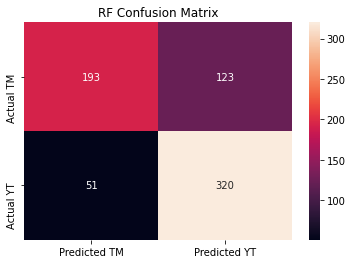

In [8]:
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index =[f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
              columns=columns, index=index)
  return sns.heatmap(table, annot=True, fmt='d')

y_pred = pipeline.predict(X_test)
ax = plot_confusion_matrix(y_test, y_pred)

ax.set_title('RF Confusion Matrix');

## Random Forest after feature selection

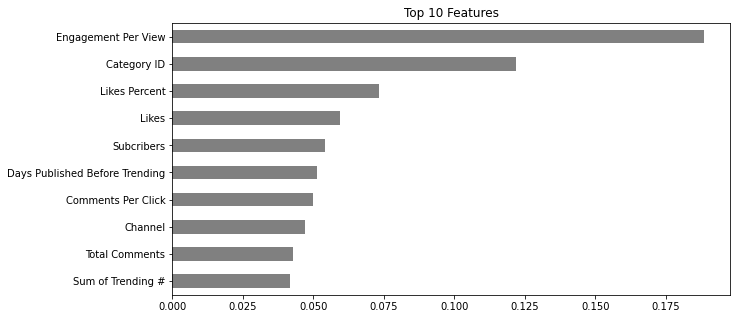

In [9]:
# Get feature importances for feature selection
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot top 10 feature importances
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} Features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [10]:
def feature_selection(X):
  X = X[['Engagement Per View', 
         'Likes Percent',
         'Comments Per Click',
         'Subcribers','Sum of Trending #',
         'Days Published Before Trending',
         'Total Comments',
         'Hour Published',
         'Category ID', 
         'Channel', 
         'Views', 
         'Likes', 
         'Dislikes',
         'classification',
         ]]
  return X

#select features
test = feature_selection(test)
train = feature_selection(train)

In [11]:
# The 'show_made_flag' column is the target
target = 'classification'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 5000
categorical_features = cardinality[cardinality <= 5000].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [12]:
#make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train);

#score pipeline before triming features
pipeline.score(X_test, y_test)

0.7947598253275109

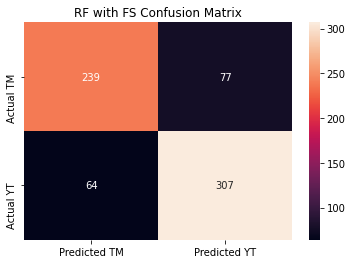

In [13]:
y_pred = pipeline.predict(X_test)
ax = plot_confusion_matrix(y_test, y_pred)

ax.set_title('RF with FS Confusion Matrix');